## ドライバーの眠気検知

### 前処理

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


## データセットの確認

In [2]:
import random
# スクリプトがあるディレクトリのパスを取得
base_dir = os.getcwd()

# 相対パスを設定
drowsy_path = os.path.join(base_dir, 'Driver Drowsiness Dataset (DDD)', 'Drowsy')
non_path = os.path.join(base_dir, 'Driver Drowsiness Dataset (DDD)', 'Non Drowsy')

image_extension = '.png'

total_drowsy = len([f for f in os.listdir(drowsy_path) if f.lower().endswith(image_extension)])
total_non = len([f for f in os.listdir(non_path) if f.lower().endswith(image_extension)])

print(f"Number of drowsy images in the folder: {total_drowsy}")
print(f"Number of non drowsy images in the folder: {total_non}")

Number of drowsy images in the folder: 22348
Number of non drowsy images in the folder: 19445


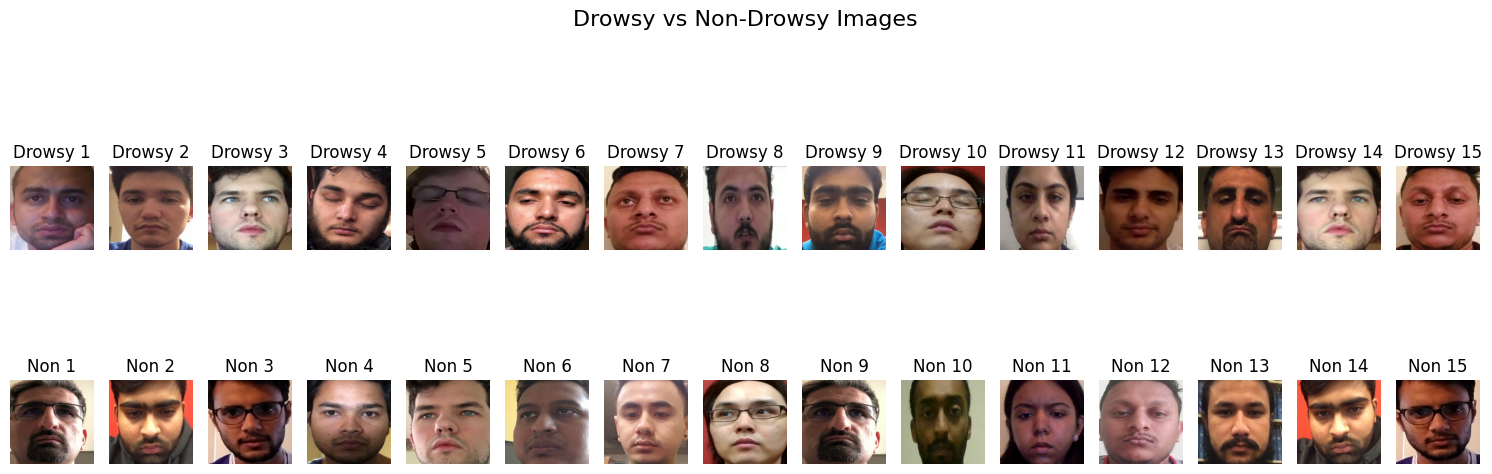

In [3]:
import random

# Load 10 random images from each path
drowsy_images = []
for filename in random.sample(os.listdir(drowsy_path), 15):
    img = Image.open(os.path.join(drowsy_path, filename))
    drowsy_images.append(img)

non_drowsy_images = []
for filename in random.sample(os.listdir(non_path), 15):
    img = Image.open(os.path.join(non_path, filename))
    non_drowsy_images.append(img)

# Create the image grid
fig, axes = plt.subplots(2, 15, figsize=(15, 6))
fig.suptitle("Drowsy vs Non-Drowsy Images", fontsize=16)

# Plot drowsy images
for i, img in enumerate(drowsy_images):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Drowsy {i+1}")

# Plot non-drowsy images
for i, img in enumerate(non_drowsy_images):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Non {i+1}")

plt.tight_layout()
plt.show()

## 前処理

In [4]:
import cv2
import dlib
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
face_detector = dlib.get_frontal_face_detector()
eye_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [5]:
# EAR計算関数
from scipy.spatial import distance
def get_eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

In [ ]:
def get_landmarks(shape):
    return [(shape.part(i).x, shape.part(i).y) for i in range(shape.num_parts)]
eye_closed_time = None  # 目を閉じた時刻を追跡

In [6]:
# データパス
drowsy_path = 'Driver Drowsiness Dataset (DDD)/Drowsy'
non_path = 'Driver Drowsiness Dataset (DDD)/Non Drowsy'

IMG_SIZE = (32, 32)  # CNN入力サイズ

def extract_eyes_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
    eye_images = []
    for (x, y, w, h) in eyes:
        eye_img = img[y:y+h, x:x+w]
        eye_img = cv2.resize(eye_img, IMG_SIZE)
        eye_images.append(eye_img)
    return eye_images

# データセット作成
X, y = [], []

for folder, label in [(drowsy_path, 1), (non_path, 0)]:
    files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
    for file in files[:1000]:  # 各クラス100枚
        img_path = os.path.join(folder, file)
        eye_imgs = extract_eyes_from_image(img_path)
        if eye_imgs:
            for eye_img in eye_imgs:
                X.append(eye_img)
                y.append(label)

In [7]:
X = np.array(X) / 255.0  # 正規化
y = to_categorical(y, num_classes=2)

# 訓練・テスト分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# データ拡張
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True)

In [9]:
# CNNモデル
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# コールバック設定
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_32.keras',          # 保存先
    monitor='val_accuracy',            # 精度を監視
    save_best_only=True,               # 精度が上がった時だけ保存
    mode='max',                         # 精度なので「max」
    verbose=1
)

# 学習
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
          validation_data=(X_test, y_test),
          epochs=30,
          callbacks=[checkpoint_cb])

Epoch 1/30


/Users/moriwataru/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/moriwataru/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5632 - loss: 0.6792
Epoch 1: val_accuracy improved from -inf to 0.63015, saving model to best_model_32.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5635 - loss: 0.6790 - val_accuracy: 0.6302 - val_loss: 0.6220
Epoch 2/30
230/231 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6262 - loss: 0.6235
Epoch 2: val_accuracy improved from 0.63015 to 0.67028, saving model to best_model_32.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6265 - loss: 0.6233 - val_accuracy: 0.6703 - val_loss: 0.5451
Epoch 3/30
229/231 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6640 - loss: 0.5762
Epoch 3: val_accuracy improved from 0.67028 to 0.71909, saving model to best_model_32.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6643 - loss: 0.5760 - val_accuracy: 0.7191 - val_loss: 0.5132
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7184 - loss: 0.5323
Epoch 4: val_accuracy improved from 

In [10]:
Image.open('box_Eyes_Limited/Drowsy/A0258.png')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,128 (1.91 MB)

 Trainable params: 167,042 (652.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334,086 (1.27 MB)

In [11]:
classes = ["Drowsy", "Non Drowsy"]
img_size = (32, 32)  # モデル学習時のサイズ
samples_per_class = 50  # 各クラスから取る枚数
dataset_dir = "Driver Drowsiness Dataset (DDD)"

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
=== Classification Report ===
              precision    recall  f1-score   support

      Drowsy       0.26      0.12      0.16        50
  Non Drowsy       0.43      0.66      0.52        50

    accuracy                           0.39       100
   macro avg       0.34      0.39      0.34       100
weighted avg       0.34      0.39      0.34       100

=== Confusion Matrix ===
[[ 6 44]
 [17 33]]


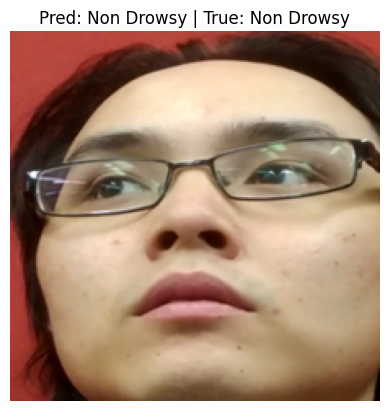

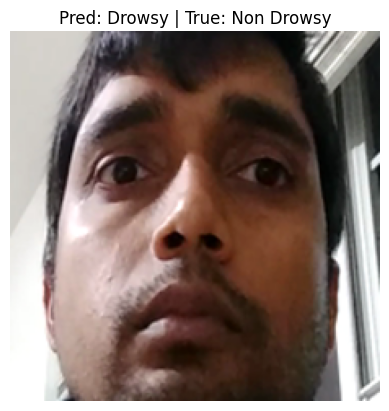

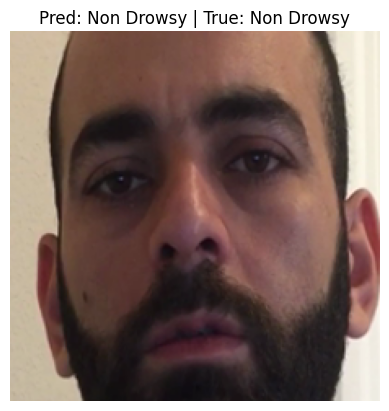

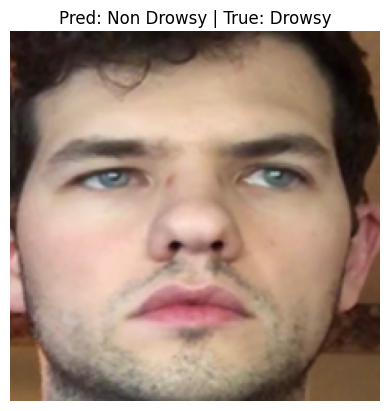

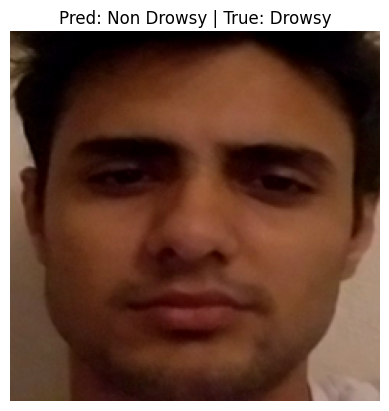

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
# 評価用データセット作成
X_test = []
y_test = []
test_images_paths = []

for idx, cls in enumerate(classes):
    class_dir = os.path.join(dataset_dir, cls)
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    selected_files = random.sample(files, min(samples_per_class, len(files)))
    for file in selected_files:
        img_path = os.path.join(class_dir, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # 正規化
        X_test.append(img)
        y_test.append(idx)
        test_images_paths.append(img_path)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 推論
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# 精度評価
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=classes))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# ランダムで数枚表示
for i in random.sample(range(len(X_test)), 5):
    plt.imshow(cv2.cvtColor(cv2.imread(test_images_paths[i]), cv2.COLOR_BGR2RGB))
    plt.title(f"Pred: {classes[y_pred[i]]} | True: {classes[y_test[i]]}")
    plt.axis("off")
    plt.show()

### データセットの準備

In [ ]:
import cv2
import threading
import numpy as np
import tensorflow as tf


# 推論結果共有用
latest_prediction = None
lock = threading.Lock()

# 推論関数（別スレッドで動かす）
def inference_worker(frame_queue):
    global latest_prediction
    while True:
        if not frame_queue:
            continue
        # 最新フレームを取得
        frame = frame_queue.pop(0)
        # 推論用に前処理
        resized = cv2.resize(frame, (64, 64))
        resized = resized / 255.0
        resized = np.expand_dims(resized, axis=0)
        # 推論
        pred = model.predict(resized, verbose=0)
        label = "Drowsy" if pred[0][0] > 0.5 else "Non_Drowsy"
        # 結果を共有変数に保存
        with lock:
            latest_prediction = label

# カメラキャプチャ開始
cap = cv2.VideoCapture(0)
frame_queue = []

# 推論スレッド開始
threading.Thread(target=inference_worker, args=(frame_queue,), daemon=True).start()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 最新フレームを推論キューに追加（最新1枚だけ保持）
    frame_queue.clear()
    frame_queue.append(frame.copy())

    # 推論結果を表示
    with lock:
        if latest_prediction is not None:
            cv2.putText(frame, latest_prediction, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("Drowsiness Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

2025-08-12 15:39:13.335 python[259:690969] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-08-12 15:39:14.487460: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at reshape_op.h:65 : INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
2025-08-12 15:39:14.488505: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/flatten_1/Reshape}}]]
Exception in thread Thread-5 (inference_worker):
Traceback (most recent call last):
  File "/Users/moriwataru/.pyenv/versions/3.11.4/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Users/moriwataru/.pyenv/versions/3.11.4/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Th

: 